In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.transforms.v2 as tfs
from torchinfo import summary
from sklearn.model_selection import train_test_split

from torchvision.models import vit_b_32, ViT_B_32_Weights, swin_t, Swin_T_Weights

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from pytorch_memlab import MemReporter

import os
import warnings
from IPython.display import clear_output

warnings.filterwarnings('ignore')

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# PATHS
PATH_TO_DATASET = './ProcessedDataset'

# IMAGES
IMAGE_WIDTH  = 224
IMAGE_HEIGHT = 224
REAL_LABEL   = 0
FAKE_LABEL   = 1

# IMAGE ENCODERS
EMBEDDING_SIZE       = 768
HID_STATE            = 1280
NUM_CLASSES          = 2   
BATCH_SIZE           = 32
DROPOUT              = 0.2
NUM_HEADS            = 8
NUM_FRAMES           = 30      # number of frames in each video
NUM_LEVELS           = 6

# TRAINING
RANDOM_SEED = 42
NUM_EPOCH   = 20
BASE_LR     = 1e-5
TRAIN_SIZE  = 0.8
VAL_SIZE    = 0.1
TEST_SIZE   = 1.0 - TRAIN_SIZE - VAL_SIZE

### Dataset

In [3]:
class DeepfakeDataset(data.Dataset):
    def __init__(self, path, deepfake_type, transform=None):
        super().__init__()

        self.path = path
        self.deepfake_type = deepfake_type
        self.transform = transform
        self.files = []
        self.targets = []
        self.len = 0

        # real videos
        path_to_real = os.path.join(self.path, 'original')
        real = os.listdir(path_to_real)
        self.files.extend(list(map(lambda x: os.path.join(path_to_real, x), real)))
        self.targets.extend([REAL_LABEL] * len(real))
        self.len += len(real)

        # fake videos
        path_to_fake = os.path.join(self.path, self.deepfake_type)
        fake = os.listdir(path_to_fake)
        self.files.extend(list(map(lambda x: os.path.join(path_to_fake, x), fake)))
        self.targets.extend([FAKE_LABEL] * len(fake))
        self.len += len(fake)

        self.targets = torch.tensor(self.targets)

    def __getitem__(self, index):
        video = self.files[index]
        t = self.targets[index].item()
        v = []

        frames = os.listdir(video)
        frames.sort(key=lambda x: int(x[6:-4])) #sorting frames since os.listdir has no order of elements

        for frame in frames:
            f = Image.open(os.path.join(video, frame))
            if (self.transform):
                f = self.transform(f)
            v.append(f)

        v = torch.stack(v)

        return v, t
    
    def __len__(self):
        return self.len

In [4]:
transforms = tfs.Compose([
    tfs.ToTensor(),
    tfs.Resize((IMAGE_WIDTH, IMAGE_HEIGHT), interpolation=tfs.InterpolationMode.BICUBIC),
    tfs.ToDtype(torch.float32),
    tfs.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [5]:
deepfakes_dataset = DeepfakeDataset(PATH_TO_DATASET, 'Deepfakes', transform=transforms)
face2face_dataset = DeepfakeDataset(PATH_TO_DATASET, 'Face2Face', transform=transforms)
faceswap_dataset = DeepfakeDataset(PATH_TO_DATASET, 'FaceSwap', transform=transforms)

print(f'Deepfakes: {len(deepfakes_dataset)}')
print(f'Face2Face: {len(face2face_dataset)}')
print(f'FaceSwap: {len(faceswap_dataset)}')

Deepfakes: 1998
Face2Face: 1999
FaceSwap: 1999


### Dataloaders

In [6]:
def get_dataloaders(dataset):
    # get split indices 
    train_idx, temp_idx = train_test_split(
        np.arange(len(dataset.targets)),
        test_size=TEST_SIZE + VAL_SIZE,
        shuffle=True,
        stratify=dataset.targets,
        random_state=RANDOM_SEED
    )
    val_idx, test_idx = train_test_split(
        temp_idx,
        test_size=TEST_SIZE / (TEST_SIZE + VAL_SIZE),
        stratify=dataset.targets[temp_idx],
        random_state=RANDOM_SEED
    )

    # make subsets
    train_dataset = data.Subset(dataset, train_idx)
    val_dataset = data.Subset(dataset, val_idx)
    test_dataset = data.Subset(dataset, test_idx)

    # make dataloaders
    train_dataloader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_dataloader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_dataloader, val_dataloader, test_dataloader

In [7]:
deepfakes_train_dataloader, deepfakes_val_dataloader, deepfakes_test_dataloader = get_dataloaders(deepfakes_dataset)
face2face_train_dataloader, face2face_val_dataloader, face2face_test_dataloader = get_dataloaders(face2face_dataset)
faceswap_train_dataloader, faceswap_val_dataloader, faceswap_test_dataloader = get_dataloaders(faceswap_dataset)

### Train functions

In [8]:
def train_model(classifier_model, train_data, val_data, save=None):
    opt = torch.optim.AdamW(classifier_model.parameters(), BASE_LR)
    loss_func = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.2, patience=3, threshold=4e-3, min_lr=1e-7)
    
    val_loss_history = []
    accuracy_history = []
    train_loss_history = []

    for _e in range(NUM_EPOCH):
        # ----- training -----
        train_loss = 0
        classifier_model.train()
        for x_batch, y_batch in tqdm(train_data, desc=f'Epoch {_e + 1}/{NUM_EPOCH} training'):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # gradient descent
            opt.zero_grad()
            output = classifier_model(x_batch)
            loss = loss_func(output, y_batch)
            train_loss += loss.item() * len(y_batch)
            
            loss.backward()
            opt.step()
        
        # ----- validation -----
        correct = 0
        total = 0
        val_loss = 0.0
        classifier_model.eval()
        with torch.no_grad():
            for x_val, y_val in tqdm(val_data, desc=f'Validation'):
                x_val, y_val = x_val.to(device), y_val.to(device)

                output = classifier_model(x_val)
                correct += torch.sum(torch.argmax(output, dim=1) == y_val).item()
                total += len(y_val)
                val_loss += loss_func(output, y_val).item() * len(y_val)

        train_loss /= len(train_data.dataset)
        val_loss /= len(val_data.dataset)
        accuracy = correct / total

        val_loss_history.append(val_loss)
        accuracy_history.append(accuracy)
        train_loss_history.append(train_loss)

        # ----- monitoring -----
        clear_output()
        print('-------------------------------')
        print(f'Epoch {_e + 1} stats')
        print(f'Train loss: {train_loss:.4f}')
        print(f'Validation accuracy: {accuracy:.4f}')
        print(f'Validation loss: {val_loss:.4f}')
        print(f'Current learning rate: {scheduler.get_last_lr()[-1]}')
        print('-------------------------------')
        
        fig, ax = plt.subplots(2)
        fig.tight_layout()

        ax[0].plot(range(_e + 1), train_loss_history, label='Train loss')
        ax[0].set_title('Train metrics')
        ax[0].legend(loc='upper left')

        ax[1].plot(range(_e + 1), val_loss_history, label='Val loss')
        ax[1].plot(range(_e + 1), accuracy_history, label='Val accuracy')
        ax[1].set_title('Val metrics')
        ax[1].legend(loc='upper left')
        
        plt.show()

        # update scheduler
        scheduler.step(val_loss)
    
    # ----- saving -----
    if (save):
        torch.save(classifier_model.state_dict(), 'models/' + save + '.tar')

In [9]:
def get_model_metrics(classifier_model, test_data):
    TP = 0
    TN = 0
    FP = 0
    FN = 0

    classifier_model.eval()
    with torch.no_grad():
        for x_test, y_test in tqdm(test_data, desc='Testing'):
            x_test, y_test = x_test.to(device), y_test.to(device)

            # get classification
            output = classifier_model(x_test)
            y_pred = torch.argmax(output, dim=1)

            for pred, real in zip(y_pred, y_test):
                if (pred == 1 and real == 1):
                    TP += 1
                elif (pred == 0 and real == 0):
                    TN += 1
                elif (pred == 1 and real == 0):
                    FP += 1
                elif (pred == 0 and real == 1):
                    FN += 1
                else:
                    raise f'Uncorrect labels; predicted: {pred}, real: {real}'

    return TP, TN, FP, FN

### Single RNN Model

In [10]:
class DeepfakeClassifierSingleRNN(nn.Module):
    def __init__(self, input_size=EMBEDDING_SIZE, hid_state=HID_STATE):
        super().__init__()

        # encoder
        self.backbone = vit_b_32(weights=ViT_B_32_Weights.IMAGENET1K_V1)
        self.backbone.eval()
        self.activations = {}

        # hooks
        self.backbone.encoder.layers[-1].register_forward_hook(self.__get_activation('final_embedding'))

        # rnn for each levels of hierarchy
        self.rnn = nn.GRU(input_size, hid_state, batch_first=True)

        # linear layer
        self.fc = nn.Linear(hid_state, NUM_CLASSES)
    
    def forward(self, x):
        self.activations = {}
        batch_size = x.shape[0]

        outputs = []
        for i in range(batch_size):
            # pass all frames to encoder
            with torch.no_grad():
                self.backbone(x[i])

            # get embeddings from different hidden states
            # embeddings.shape = [seq_len, num_hid_states, frames_hid_state]
            final_embedding = self.activations['final_embedding']

            # rnn for each levels of hierarchy
            out, _ = self.rnn(final_embedding)
            outputs.append(out[-1])
        
        # get logits
        # outputs.shape = [batch_size, NUM_LEVELS * hid_state]
        outputs = torch.stack(outputs)
        logits = self.fc(outputs)
            
        return logits

    def __get_activation(self, name):
        def hook(model, input, output):
            # getting only CLS tokens
            self.activations[name] = output[:, 0, :].detach()
        return hook

#### Deepfakes

-------------------------------
Epoch 20 stats
Train loss: 0.1384
Validation accuracy: 0.8900
Validation loss: 0.3408
Current learning rate: 2.0000000000000003e-06
-------------------------------


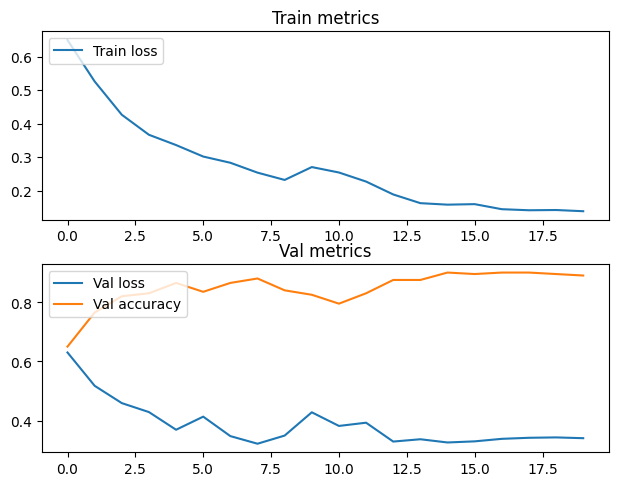

In [22]:
rnn_deepfakes = DeepfakeClassifierSingleRNN().to(device)
if (os.path.exists('models/single_rnn/rnn_deepfakes.tar')):
    rnn_deepfakes.load_state_dict(torch.load('models/rnn_deepfakes.tar', weights_only=True))
else:
    train_model(rnn_deepfakes, deepfakes_train_dataloader, deepfakes_val_dataloader, 'single_rnn/rnn_deepfakes')

In [23]:
rnn_deepfakes.eval()
TP, TN, FP, FN = get_model_metrics(rnn_deepfakes, deepfakes_test_dataloader)

print(f'True Positive:  {TP}')
print(f'True Negative:  {TN}')
print(f'False Positive: {FP}')
print(f'False Negative: {FN}')
print('-----------------------')
print(f'Accuracy: {(TP + TN) / (TP + TN + FP + FN) * 100}%')

Testing: 100%|██████████| 7/7 [00:09<00:00,  1.31s/it]

True Positive:  87
True Negative:  93
False Positive: 7
False Negative: 13
-----------------------
Accuracy: 90.0%


#### Face2Face

In [19]:
rnn_face2face = DeepfakeClassifierSingleRNN().to(device)
if (os.path.exists('models/single_rnn/rnn_face2face.tar')):
    rnn_face2face.load_state_dict(torch.load('models/single_rnn/rnn_face2face.tar', weights_only=True))
else:
    train_model(rnn_face2face, face2face_train_dataloader, face2face_val_dataloader, 'single_rnn/rnn_face2face')

In [20]:
rnn_face2face.eval()
TP, TN, FP, FN = get_model_metrics(rnn_face2face, face2face_test_dataloader)

print(f'True Positive:  {TP}')
print(f'True Negative:  {TN}')
print(f'False Positive: {FP}')
print(f'False Negative: {FN}')
print('-----------------------')
print(f'Accuracy: {(TP + TN) / (TP + TN + FP + FN) * 100}%')

Testing: 100%|██████████| 7/7 [00:09<00:00,  1.34s/it]

True Positive:  75
True Negative:  82
False Positive: 18
False Negative: 25
-----------------------
Accuracy: 78.5%


#### FaceSwap

-------------------------------
Epoch 20 stats
Train loss: 0.2426
Validation accuracy: 0.8050
Validation loss: 0.4770
Current learning rate: 2.0000000000000003e-06
-------------------------------


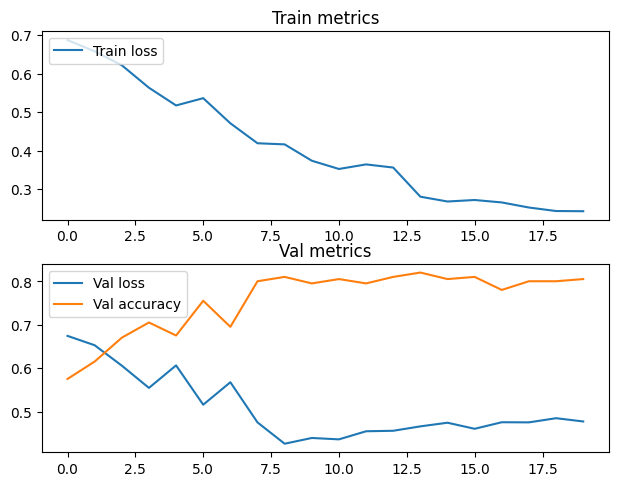

In [13]:
rnn_faceswap = DeepfakeClassifierSingleRNN().to(device)
if (os.path.exists('models/single_rnn/rnn_faceswap.tar')):
    rnn_faceswap.load_state_dict(torch.load('models/single_rnn/rnn_faceswap.tar', weights_only=True))
else:
    train_model(rnn_faceswap, faceswap_train_dataloader, faceswap_val_dataloader, 'single_rnn/rnn_faceswap')

In [14]:
rnn_faceswap.eval()
TP, TN, FP, FN = get_model_metrics(rnn_faceswap, faceswap_test_dataloader)

print(f'True Positive:  {TP}')
print(f'True Negative:  {TN}')
print(f'False Positive: {FP}')
print(f'False Negative: {FN}')
print('-----------------------')
print(f'Accuracy: {(TP + TN) / (TP + TN + FP + FN) * 100}%')

Testing: 100%|██████████| 7/7 [00:09<00:00,  1.35s/it]

True Positive:  72
True Negative:  77
False Positive: 23
False Negative: 28
-----------------------
Accuracy: 74.5%
